# Main idea.

The main idea for this project, is to develop a sentiment classifier using **feed-forward** neural network for the [Twitter sentiment analysis dataset](https://drive.google.com/file/d/1dTIWNpjlrnTQBIQtaGOh0jCRYZiAQO79/view). 

We'll do some expirements with all the possible hyperparameters, like the number of hidden layers, activation functions, loss functions, optimizers, etc. <!-- Also, we'll use pre-trained word embendding vectors, using [GloVe](https://nlp.stanford.edu/projects/glove/). -->

#(1) Libraries and files:

In [ ]:
!pip install d2l==0.15.0

     |████████████████████████████████| 61kB 6.4MB/s 


In [ ]:
#Importing all the libraries that we are going to need for this assignment.

#Pandas
import pandas as pd
from pandas import read_csv
import csv
pd.set_option('display.max_rows', None)                                         #See all rows

#Numpy
import numpy  as np

#Natural Language Toolkit
import nltk
import nltk.corpus

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
stop = stopwords.words('english')

#Sklearn

from sklearn.feature_extraction.text import TfidfVectorizer                     #tf-idf
from sklearn.feature_extraction.text import CountVectorizer                     #BoW

from sklearn.model_selection import train_test_split, cross_val_score           #To divide our data evenly
from sklearn import preprocessing                                               #Create numeric categories using the LabelEncoder and fit-trasnsform pipeline
from sklearn.feature_selection import SelectKBest, chi2                         #Select the best features from vocabulary

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

import re
from bs4 import BeautifulSoup

#PyTorch

from d2l import torch as d2l
import torch
import torch.nn as nn
import torch.optim as optim

#Matplot

from matplotlib import pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# (2) Functions:

These functions are for data cleaning and preprocessing.

In [ ]:
def sum1forline(filename,nrows):                                                #Calculating the rows in a csv file
    with open(filename) as f:
        total_lines = sum(1 for line in f)
        if ( total_lines > nrows ):
          print("We have:", total_lines ,"rows in total and we've read:",nrows,"samples")
        else:
          print("We have:", total_lines ,"rows in total and we've read:",total_lines,"samples")



def cleanText(tweets):
  tweets['text'] = tweets['text'].apply(lambda x: str(x).lower())                                                 #Make the text in lowercase

  tweets['text'] = tweets['text'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text().strip())                    #Removing HTML Tags

  tweets['text'] = tweets['text'].apply(lambda x: RemoveSpecialCharacters(x))                                     #Remove special characters (#!@%*& etc)

  tweets['text'] = tweets['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))   #Removing stopwords

  tweets['text'] = tweets['text'].apply(lambda x: removeNumbers(x))                                               #Removing numbers

  #Steeming: "rained" , "raining" , "rain" converting into: "rain".

  tweets['text_tokens'] = tweets['text'].apply(lambda x: word_tokenize(x))
  #Uncomment the next lines if you want to choose steeming over leematization

  # <-->
  tweets['text_tokens_final'] = tweets['text_tokens'].apply(lambda x: word_stemmer(x))
  # <-->

  #Leematization: "rocks" : rock , "corpora" : corpus, "better" : good.
  #Comment the next line if you want to choose steeming over leematization

  # <-->
  # tweets['text_tokens_final'] = tweets['text_tokens'].apply(lambda x: word_lemmatizer(x))
  # <-->

  #Final text

  tweets['final_text'] = tweets['text_tokens_final'].apply(lambda x: list2string(x))

  tweets['final_text'] =  tweets['final_text'].apply(lambda x: re.sub(r"\b[a-zA-Z]\b", "", x))                      #Remove all the single characters from a string

  tweets['final_text'] = tweets['final_text'].apply(lambda x: re.sub(' +', ' ', x))                                 #Replace multiple whitespaces

  #Clean the csv file from odd columns
  tweets = tweets.drop(['text', 'text_tokens', 'text_tokens_final'], axis=1)
  
  columns_titles = ["final_text","sentiment"]
  tweets=tweets.reindex(columns=columns_titles)

  tweets.columns= ['text', 'sentiment']                        

  return tweets

def removeNumbers(text):
  result = ''.join([i for i in text if not i.isdigit()])
  return result

def RemoveSpecialCharacters(x):

  cleanString = re.sub('\W+',' ', x )
  cleanString= ' '.join(cleanString.split())
  return cleanString

def word_stemmer(text):
    stem_text = [PorterStemmer().stem(i) for i in text]
    return stem_text

def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text

def list2string(list):
  # initialize an empty string 
  str1 = " " 
    
  # return string   
  return (str1.join(list)) 

def Word_Vectorizer(X_train, Y_train, X_test, Y_test, method, kBestFeatures):   #Vectorization with feature selection
    
    y_train = Y_train
    y_test  = Y_test

    le = preprocessing.LabelEncoder()
    le.fit(Y_train)
    
    #Y_train and Y_test form now and then , will have numeric values instead of strings
    #Same for X_train and X_test

    Y_train = le.transform(Y_train)
    Y_test  = le.transform(Y_test)

    vectorizer = method()

    X_train = vectorizer.fit_transform(X_train)
    X_train_reduced = SelectKBest(chi2, k=kBestFeatures).fit_transform(X_train, y_train )

    X_test  = vectorizer.transform(X_test)
    X_test_reduced = SelectKBest(chi2, k=kBestFeatures).fit_transform(X_test, y_test)

    return X_train_reduced, Y_train, X_test_reduced, Y_test
    # return X_train, Y_train, X_test, Y_test

def convert2Torch(X_train, X_test, Y_train, Y_test):
  
  X_train = X_train.toarray()
  X_test  = X_test.toarray()
  X_train = torch.from_numpy(X_train).to(device)
  X_test  = torch.from_numpy(X_test).to(device)


  Y_train = np.array([Y_train]).T

  Y_test  = np.array([Y_test]).T

  Y_train = torch.from_numpy(Y_train).to(device)
  Y_test  = torch.from_numpy(Y_test).to(device)

  return X_train, X_test, Y_train, Y_test

def loadGloveModel(File):
  print("Loading Glove Model")

  f = open(File,'r')

  gloveModel = {}

  for line in f:
  
    splitLines = line.split()
    word = splitLines[0]
    wordEmbedding = np.array([float(value) for value in splitLines[1:]])
    gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
  
  return gloveModel

These functions are for creating our FF-Neural Network.

In [ ]:
class FeedForward_NN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):

    super(FeedForward_NN, self).__init__()

    # Linear Layer 1: Input Layer. fc stands for fully conected layer
    self.fc1 = nn.Linear(input_size, hidden_size)

    # 1st Activation Function
    self.relu1 = nn.ReLU()
    # self.sigmoid1 = nn.Sigmoid()

    # Linear Layer 2: Hidden Layer.
    self.fc2 = nn.Linear(hidden_size, hidden_size)

    # 2nd Activation Function
    self.relu2 = nn.ReLU()
    # self.sigmoid2 = nn.Sigmoid()

    # Linear Layer 3: Output Layer.
    self.fc3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):

    # Linear 1:
    x = self.fc1(x)

    # 1st Activation
    x = self.relu1(x)
    # x = self.sigmoid1(x)

    # Linear 2:
    x = self.fc2(x)

    # 2nd Activation
    x = self.relu2(x)
    # x = self.sigmoid2(x)

    #Linear 3:
    x = self.fc3(x)

    # Output Activation Function
    # output = nn.Softmax(dim=0)
    output = nn.functional.softmax(x, dim=0)
    
    return output

def visual_loss():
  
  plt.plot(iter,train_loss)
  
  plt.xlabel('Epochs')
  
  plt.ylabel('Train Loss')

These functions are for training our FF-Neural Network.

In [ ]:
def training(X_train, Y_train, num_epochs, optimizer, loss, net):

  train_loss = [] 
  iter = []

  train_iter = d2l.load_array((X_train, Y_train), batch_size)


  for epoch in range(num_epochs):

    for X, y in train_iter:

      # Set the accumulated gradients to zero before starting backpro
      optimizer.zero_grad()

      # Forward Pass into the FF Neural Network
      y_pred = net(X.float())
      # print(y_pred)
      # print(y)

      # Compute Loss
      loss_func = loss(y_pred, torch.argmax(y,1))
      # loss_func = loss(y_pred,y)
      # loss_func = loss(torch.argmax(y_pred, dim=1), y)

      # Computing gradients
      # Backward pass
      loss_func.backward()

      # Updating Parameters
      optimizer.step()
    
    train_loss.append( loss_func.item() )
    iter.append( epoch + 1 )
    print("Epoch:",epoch + 1,"completed.")
    print("Training loss:",loss_func.item(),"\n")

  return train_loss, iter

Here, the evaluation will take place.

In [ ]:
def evaluate(X_test, Y_test, net, batch_size):

  test_iter = d2l.load_array((X_test, Y_test), batch_size)

  ff_nn_val_predictions= []
  real_labels = []

  with torch.no_grad():

    for X, y in test_iter:
    
      probs = net(X.float())
      ff_nn_val_predictions.append(torch.argmax(probs,dim=1).cpu().numpy()[0])
      real_labels.append(y.cpu().numpy()[0])

  print(classification_report(ff_nn_val_predictions, real_labels))
  print("Accuracy Score -> ",   accuracy_score(   ff_nn_val_predictions, real_labels))
  print("Precision Score -> ",  precision_score(  ff_nn_val_predictions, real_labels, average='macro')*100)
  print("Recall Score -> ",     recall_score(     ff_nn_val_predictions, real_labels, average='macro')*100)
  print("F-Measure Score -> ",  f1_score(         ff_nn_val_predictions, real_labels, average='macro')*100)

Last but not least, we'll use the given GPU from google colab in order to make our computations a bit faster.

In [ ]:
def use_cuda():

  if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

  else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Device available for running: ")
  print(device)
  return device

# (3) Data Preprocessing:

In [ ]:
#Loading and previewing the given dataset.

#How much lines you want to read (Use this in order to save the given RAM)
samples = 1000000

LocationCSV = r'/content/SentimentTweets.csv'
tweets = pd.read_csv(LocationCSV, low_memory=False , quoting=csv.QUOTE_NONE, encoding='utf-8',  warn_bad_lines=False, error_bad_lines=False, nrows=samples);   #Read csv file
tweets.head()

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


In [ ]:
sum1forline(LocationCSV,samples)  #Calculating the rows in a csv file (When the file it's fully read, rows we'll be 1.280.001)
tweets = cleanCSV(tweets)         #Drop useless columns
tweets = cleanText(tweets)        #Data Preprocessing/Text cleaning => Takes some time
tweets.head()

We have: 144509 rows in total and we've read: 144509 samples


,text,sentiment
0,brokenpromis,negative
1,david carradin sad thai law sure fowl play man...,negative
2,tell bro say congrat,positive
3,littlefluffycat inde,positive
4,complet race life min girli work fun bloodi ho...,positive


In [ ]:
#Dividing the dataset into train and test.

X = tweets['text']
y = tweets['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)       #Splitting our dataset

print(y_train.value_counts())
print(y_test.value_counts())

negative    45201
positive    43784
Name: sentiment, dtype: int64
negative    11253
positive    10994
Name: sentiment, dtype: int64


In order to minimize our vocabulary, we'll do some feature extraction. The selection of the k-best features though, will go through the chi2 filter.

In [ ]:
kBestFeatures = 1000 
vec_method    = TfidfVectorizer
# vec_method    = CountVectorizer


X_train, Y_train, X_test, Y_test = Word_Vectorizer(X_train, y_train, X_test, y_test, vec_method, kBestFeatures)       #Vectorization

Now, we'll convert our data into the tensor representation for training.

Our datasets have a sparse matrix form, meaning that the most elements in the matrix are zeros.

In [ ]:
device = use_cuda()
X_train, X_test, Y_train , Y_test = convert2Torch(X_train, X_test, Y_train, Y_test)

There are 1 GPU(s) available.
Device name: Tesla T4
Device available for running: 
cuda


# (4) Training our FF Neural Network:

First of all, we need to initialize our model. In order to do this, we must compute 3 basic componets:


1. *Input Dimension*.
2. *Hidden Dimension*.
3. *Output Dimension*.

The first one is simply the number of features in our training dataset.

The last one is also an easy one, we have only 2 labels for each comment: Negative/Positive. Thus, the output_dim will be **2**.

Now, the number of the units in hidden layer varies. After some expirements, we choose **500** units.

Last but not least, we choose 2 activation functions:



*   For Hidden Layers: **ReLU** (or **Sigmoid**).
*   For Output Layers: **Softmax**.



In [ ]:
input_size  = X_train.shape[1]
hidden_size = 500
output_size = 2

net = FeedForward_NN(input_size, hidden_size, output_size)
net.to(device)

FeedForward_NN(
  (fc1): Linear(in_features=1000, out_features=500, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=500, out_features=2, bias=True)
)

Now, let's configure the hyperparameters for the training set.

In [ ]:
num_epochs    = 10          # Number of epochs
learning_rate = 0.001       # Learning Rate
batch_size    = 64          # After how many samples we'll change the weights
# weight_decay  = 0.01        # L2 Penalty (Optional here)

Now, we must also choose which lost function we should use, and also the optimizer. After some tests, we decided that the best combination for our occasion is:


*   Loss Function: **CrossEntropyLoss**
*   Optimizer: **Adam**



In [ ]:
loss = nn.CrossEntropyLoss()
# loss = nn.MSELoss()
# loss = nn.BCELoss()

optimizer = optim.Adam(net.parameters(), lr = learning_rate)
# optimizer     = optim.SGD(net.parameters(), lr= learning_rate)

So now we are ready to train our model! Then, we'll use some graphic data representation and also we'll see how good scores we managed to have.

In [ ]:
train_loss, iter = training(X_train, Y_train, num_epochs, optimizer, loss, net)

Epoch: 1 completed.
Training loss: 0.6931471228599548 

Epoch: 2 completed.
Training loss: 0.6931471824645996 

Epoch: 3 completed.
Training loss: 0.6931471228599548 

Epoch: 4 completed.
Training loss: 0.6931471228599548 

Epoch: 5 completed.
Training loss: 0.6931473016738892 

Epoch: 6 completed.
Training loss: 0.6931471824645996 

Epoch: 7 completed.
Training loss: 0.6931471824645996 

Epoch: 8 completed.
Training loss: 0.6931473016738892 

Epoch: 9 completed.
Training loss: 0.6931471824645996 

Epoch: 10 completed.
Training loss: 0.6931471228599548 



In [ ]:
evaluate(X_test, Y_test, net, batch_size)

              precision    recall  f1-score   support

           0       0.52      0.50      0.51       183
           1       0.47      0.49      0.48       165

    accuracy                           0.50       348
   macro avg       0.50      0.50      0.50       348
weighted avg       0.50      0.50      0.50       348

Accuracy Score ->  0.49712643678160917
Precision Score ->  49.682875264270606
Recall Score ->  49.68206656731247
F-Measure Score ->  49.662349255680546


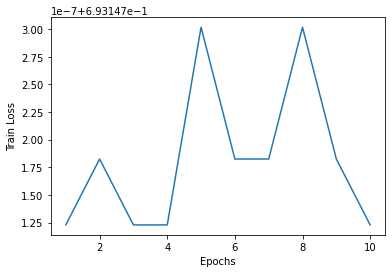

In [ ]:
visual_loss()